## Train Linear Head

In [ ]:
import os
import glob
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Config
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT   = "data/eurosat/eurosat/2750"  # <-- deine JPEG-Ordnerstruktur
BACKBONE_CKPT = "runs/barlow_twins_ssl4eo_rgb_100000_res18_aug/checkpoints/barlow_epoch100.pt"
CKPT_DIR    = "runs/linear_probe_eurosat_res18_new_metrics/checkpoints_linear_probe_res18_new_metrics"
LOG_DIR     = "runs/linear_probe_eurosat_res18_new_metrics"
NUM_EPOCHS  = 100
BATCH_SIZE  = 256
LR          = 0.01
MOMENTUM    = 0.9
WEIGHT_DECAY= 1e-4
NUM_CLASSES = 10

# Create directories if not already existing
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 2) Define class names for EuroSAT dataset
class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
    "Industrial", "Pasture", "PermanentCrop", "Residential",
    "River", "SeaLake"
]

# 3) Image preprocessing pipeline (resize, crop, normalize)
mean = [0.48241806, 0.48080587, 0.47794071]
std = [0.19021621, 0.16879530, 0.14623168]
preproc = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# 4) Dataset wrapper for EuroSAT images (JPG format)
class EuroSATJPG(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.paths = glob.glob(os.path.join(root_dir, "*", "*.jpg"))
        self.paths.sort()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = os.path.basename(os.path.dirname(path))  # Folder name as label
        y = class_names.index(label)  # Convert label to index
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)  # Apply transformation
        return img, y


# 5) DataLoader for training and validation
ds = EuroSATJPG(DATA_ROOT, transform=preproc)
n = len(ds)
n_train = int(0.8 * n)  # 80% for training
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, n - n_train])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 6) Save the validation dataset images and labels
def save_dataset(dataset, filename):
    """Save dataset images and their labels as tensors."""
    data = []
    labels = []
    for img, label in dataset:
        data.append(img)
        labels.append(label)
    
    # Convert lists to tensors
    data_tensor = torch.stack(data)  # Stack images into a single tensor
    labels_tensor = torch.tensor(labels)  # Convert labels to tensor
    
    # Save tensors to file
    torch.save((data_tensor, labels_tensor), filename)

# Save validation dataset
save_dataset(val_ds, "val_dataset.pth")


# 7) Load the pre-trained backbone (ResNet-18)
feat_dim = 512  # Feature dimension after the backbone for ResNet-18
encoder = models.resnet18(pretrained=False)
encoder.fc = nn.Identity()  # Remove the final classification layer
ckpt = torch.load(BACKBONE_CKPT, map_location=DEVICE)  # Load the checkpoint
state = {k.replace("backbone.", ""): v for k, v in ckpt["model_state_dict"].items() if k.startswith("backbone.")}
encoder.load_state_dict(state, strict=True)  # Load the weights into the encoder
encoder.to(DEVICE).eval()  # Set to evaluation mode
for p in encoder.parameters():
    p.requires_grad = False  # Freeze encoder weights

# 8) Define the linear head for classification
head = nn.Linear(feat_dim, NUM_CLASSES).to(DEVICE)

# 9) Loss function, optimizer, learning rate scheduler, and TensorBoard writer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.SGD(head.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)  # Optimizer
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate scheduler
writer = SummaryWriter(log_dir=LOG_DIR)  # TensorBoard logging

# --- Projector config for embeddings ---
metadata_path = os.path.join(LOG_DIR, "metadata.tsv")
with open(metadata_path, "w") as f:
    f.write("Label\n")  # Header for the metadata file
projector_config = f"""
embeddings {{
  tensor_name: "LinearProbe/Embeddings"
  metadata_path: "{os.path.basename(metadata_path)}"
}}
"""
with open(os.path.join(LOG_DIR, "projector_config.pbtxt"), "w") as f:
    f.write(projector_config)


# 10) Training and Validation Loop
best_val_acc = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    # -- Training --
    head.train()  # Set the head to training mode
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{NUM_EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            feats = encoder(x)  # Extract features from the encoder
        logits = head(feats)  # Pass features through the linear head
        loss = criterion(logits, y)  # Compute loss
        optimizer.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update weights

        running_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)  # Get the predicted class
        correct += (pred == y).sum().item()  # Count correct predictions
        total += y.size(0)
        all_preds.append(pred.cpu())
        all_labels.append(y.cpu())

    # Compute and log training metrics
    train_loss = running_loss / total
    train_acc = correct / total
    scheduler.step()  # Update learning rate
    writer.add_scalar("LinearProbe/Train_Loss", train_loss, epoch)
    writer.add_scalar("LinearProbe/Train_Acc", train_acc, epoch)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    writer.add_scalar("LinearProbe/Train_Precision", precision_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Train_Recall", recall_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Train_F1", f1_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)

    # -- Validation --
    head.eval()  # Set the head to evaluation mode
    correct, total = 0, 0
    all_feats, all_preds_list, all_labels_list, all_imgs = [], [], [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            feats = encoder(x)
            logits = head(feats)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # Collect data for visualization
            all_feats.append(feats.cpu())
            all_preds_list.append(pred.cpu())
            all_labels_list.append(y.cpu())
            all_imgs.append(x.cpu())

    val_acc = correct / total
    writer.add_scalar("LinearProbe/Val_Acc", val_acc, epoch)

    # -- Validation Metrics --
    val_preds = torch.cat(all_preds_list)
    val_labels = torch.cat(all_labels_list)
    writer.add_scalar("LinearProbe/Val_Precision", precision_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Val_Recall", recall_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Val_F1", f1_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)

    # --- Embedding-Logging (subsampled) ---
    feats_cat = torch.cat(all_feats)
    labels_cat = torch.cat(all_labels_list)

    # Subsampling to limit the number of embeddings for visualization
    max_pts = 1000
    if feats_cat.size(0) > max_pts:
        idx = torch.randperm(feats_cat.size(0))[:max_pts]
        feats_sample = feats_cat[idx]
        labels_sample = labels_cat[idx].tolist()
    else:
        feats_sample = feats_cat
        labels_sample = labels_cat.tolist()

    writer.add_embedding(
        mat=feats_sample,
        metadata=labels_sample,
        global_step=epoch,
        tag="LinearProbe/Embeddings"
    )

    # --- t-SNE visualization ---
    tsne = TSNE(n_components=2)
    feats_2d = tsne.fit_transform(feats_sample.numpy())
    fig_tsne, ax_tsne = plt.subplots()
    ax_tsne.scatter(feats_2d[:, 0], feats_2d[:, 1], c=labels_sample, s=5)
    ax_tsne.set_title(f"t-SNE Val (Epoch {epoch})")
    writer.add_figure("LinearProbe/tSNE_Val", fig_tsne, epoch)
    plt.close(fig_tsne)

    # --- Confusion Matrix ---
    cm = confusion_matrix(labels_cat.tolist(), val_preds.tolist())
    fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names,
                ax=ax_cm)
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    writer.add_figure("LinearProbe/ConfusionMatrix_Val", fig_cm, epoch)
    plt.close(fig_cm)

    print(f"Epoch {epoch:03d} | Train: {train_loss:.4f}/{train_acc:.3f} | Val: {val_acc:.3f}")

    # -- Save best model checkpoint --
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        path = os.path.join(CKPT_DIR, f"best_head_epoch{epoch:03d}.pth")
        torch.save({"epoch": epoch, "head_state_dict": head.state_dict(), "val_acc": val_acc}, path)

# -- Save final model --
final_path = os.path.join(CKPT_DIR, "head_final.pth")
torch.save(head.state_dict(), final_path)
print(f"Final head saved at {final_path}")
writer.close()


2025-06-27 14:57:25.682896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751036245.920656    8576 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751036245.988316    8576 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751036246.532748    8576 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751036246.532776    8576 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751036246.532779    8576 computation_placer.cc:177] computation placer alr

Epoch 001 | Train: 1.2204/0.572 | Val: 0.713


[Train] Epoch 2/100: 100%|██████████| 85/85 [00:18<00:00,  4.59it/s]


Epoch 002 | Train: 0.8163/0.719 | Val: 0.760


[Train] Epoch 3/100: 100%|██████████| 85/85 [00:18<00:00,  4.56it/s]


Epoch 003 | Train: 0.7519/0.741 | Val: 0.773


[Train] Epoch 4/100:  29%|██▉       | 25/85 [00:06<00:12,  4.85it/s]

## Create Metrics

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


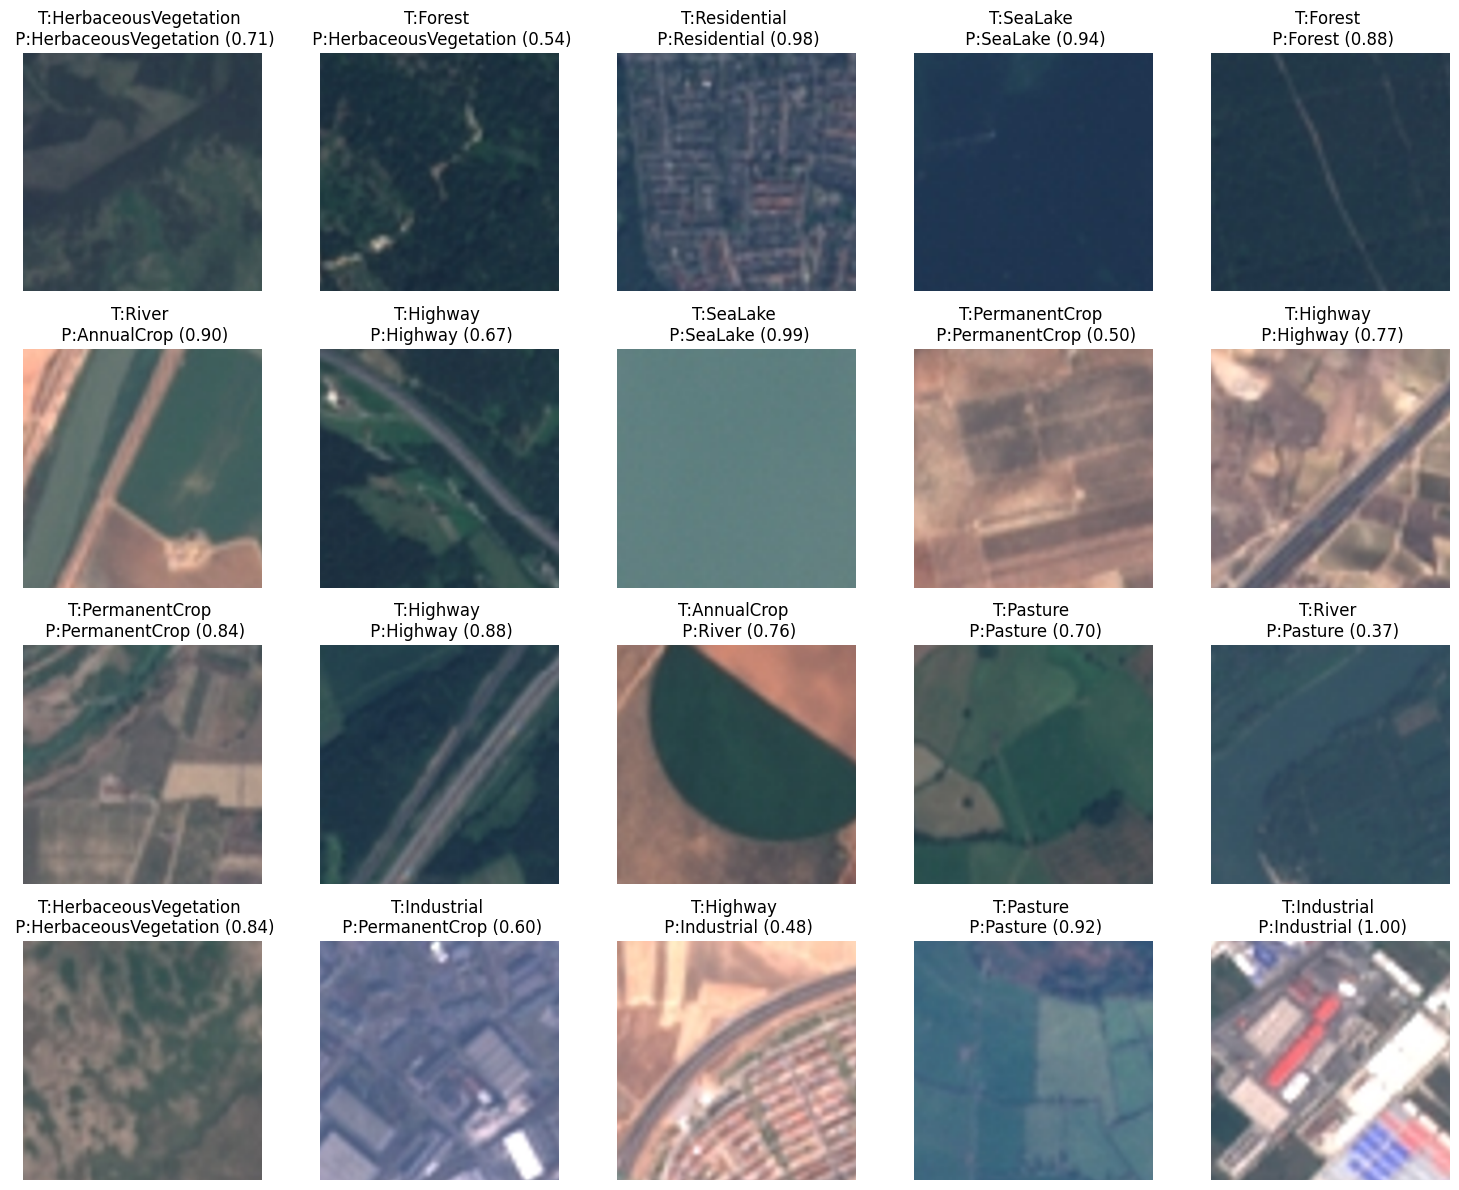

Collage gespeichert als collage_res18.png


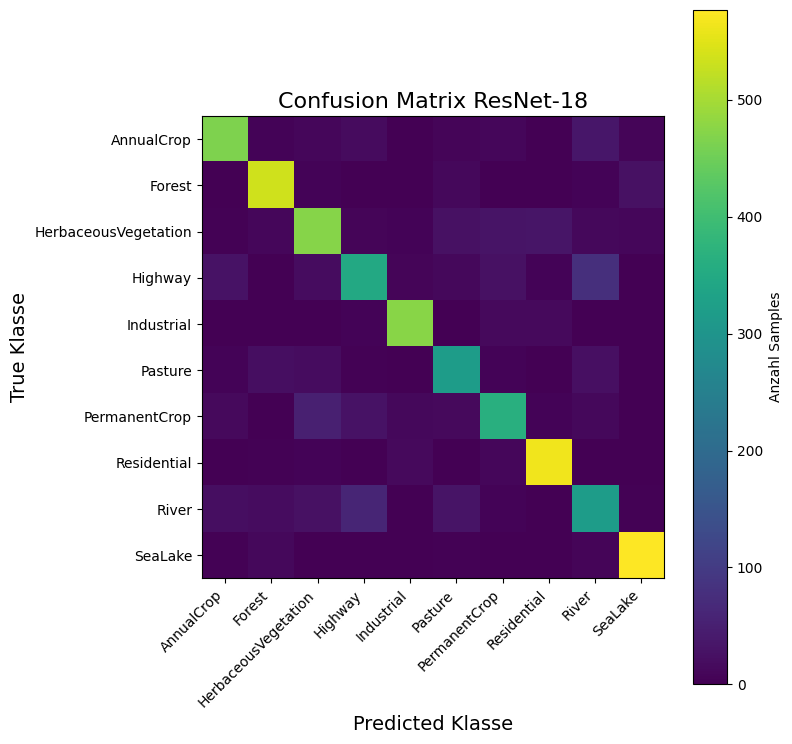

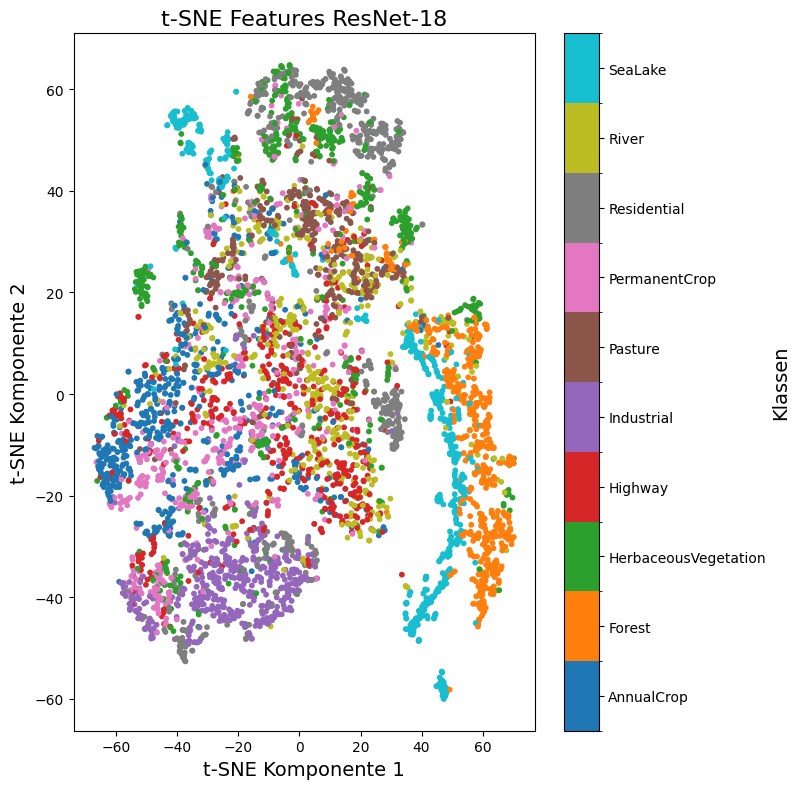

In [1]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
import random
import matplotlib.colors as mcolors

# --- Einstellungen ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

# Inverse-Normalisierung (für Anzeige)
mean = torch.tensor([0.48241806, 0.48080587, 0.47794071])
std  = torch.tensor([0.19021621, 0.16879530, 0.14623168])
def unnormalize(img_tensor):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
    return Image.fromarray(img)

# Transform für rohe Bilder
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# --- Encoder ResNet-18 laden ---
encoder = models.resnet18(pretrained=False)
encoder.fc = torch.nn.Identity()
encoder.to(device)
encoder.eval()
# SSL-Backbone laden
ckpt_ssl = torch.load(
    "runs/barlow_twins_ssl4eo_rgb_100000_res18_aug/checkpoints/barlow_epoch100.pt",
    map_location=device
)
state = {k.replace("backbone.", ""): v for k, v in ckpt_ssl["model_state_dict"].items()
         if k.startswith("backbone.")}
encoder.load_state_dict(state, strict=True)

# Linear Head laden
feat_dim = 512
head = torch.nn.Linear(feat_dim, len(class_names)).to(device)
ckpt_lp = torch.load(
    "runs/linear_probe_eurosat_res18_new_metrics/checkpoints_linear_probe_res18_new_metrics/head_final.pth",
    map_location=device
)
if "head_state_dict" in ckpt_lp:
    head.load_state_dict(ckpt_lp["head_state_dict"])
else:
    head.weight.data = ckpt_lp["weight"]
    head.bias.data   = ckpt_lp["bias"]
head.eval()

# --- Validation Data laden ---
val_dataset = torch.load(os.path.expanduser("~/val_dataset.pth"), map_location=device)
if isinstance(val_dataset, (list, tuple)) and len(val_dataset)==2 and isinstance(val_dataset[0], torch.Tensor):
    images_tensor, labels_tensor = val_dataset
    use_tensor_input = True
    total = images_tensor.size(0)
else:
    use_tensor_input = False
    total = len(val_dataset)

# --- Zufällige Collage anzeigen ---
num_samples = 20
indices = random.sample(range(total), num_samples)
fig, axes = plt.subplots(4, 5, figsize=(15,12))
for ax, idx in zip(axes.flatten(), indices):
    if use_tensor_input:
        x = images_tensor[idx].unsqueeze(0).to(device)
        true_label = int(labels_tensor[idx].item())
    else:
        sample = val_dataset[idx]
        img = sample.get("image", sample.get("img", None)) if isinstance(sample, dict) else sample[0]
        true_label = sample.get("label", sample.get("target", sample[1])) if isinstance(sample, dict) else int(sample[1])
        x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feats  = encoder(x)
        logits = head(feats)
        probs  = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    img_pil = unnormalize(x[0])
    ax.imshow(img_pil)
    ax.set_title(f"T:{class_names[true_label]} \n P:{class_names[pred]} ({probs[0,pred]:.2f})")
    ax.axis('off')
plt.tight_layout()
plt.savefig("collage_res18.png", dpi=150, bbox_inches='tight')
#plt.show()
print("Collage gespeichert als collage_res18.png")

# --- Inferenz und Merkmalsextraktion ---
y_true, y_pred, features_list = [], [], []
for idx in range(total):
    if use_tensor_input:
        x = images_tensor[idx].unsqueeze(0).to(device)
        label = int(labels_tensor[idx].item())
    else:
        sample = val_dataset[idx]
        if isinstance(sample, dict):
            img = sample.get("image", sample.get("img"))
            label = int(sample.get("label", sample.get("target", -1)))
        else:
            img, label = sample[0], int(sample[1])
        x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat   = encoder(x)
        logits = head(feat)
        probs  = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()

    y_true.append(label)
    y_pred.append(pred)
    features_list.append(feat.cpu().squeeze().numpy())

# --- Confusion Matrix ResNet-18 ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix ResNet-18", fontsize=16)
plt.xlabel("Predicted Klasse", fontsize=14)
plt.ylabel("True Klasse", fontsize=14)
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar(label="Anzahl Samples")
plt.tight_layout()
plt.savefig("confusion_matrix_res18.png", dpi=150, bbox_inches='tight')
plt.show()

# --- t-SNE Features ResNet-18 ---
features = np.stack(features_list)
tsne = TSNE(n_components=2, random_state=42)
z = tsne.fit_transform(features)
plt.figure(figsize=(8,8))
# Diskrete Farbkarte
cmap = plt.get_cmap('tab10', len(class_names))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_names)+1)-0.5, ncolors=cmap.N)
scatter = plt.scatter(z[:,0], z[:,1], c=y_true, cmap=cmap, norm=norm, s=10)
plt.title("t-SNE Features ResNet-18", fontsize=16)
plt.xlabel("t-SNE Komponente 1", fontsize=14)
plt.ylabel("t-SNE Komponente 2", fontsize=14)
# Farbbar mit Klassennamen
cbar = plt.colorbar(scatter, ticks=np.arange(len(class_names)))
cbar.ax.set_yticklabels(class_names)
cbar.set_label("Klassen", fontsize=14)
plt.tight_layout()
plt.savefig("tsne_res18.png", dpi=150, bbox_inches='tight')
plt.show()
